# SI 618 - Homework #7: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

Version 2023.11.08.1.CT

This is, perhaps, one of the most exciting homework assignments that you have encountered in this course!

You are going to try your hand at a Kaggle competition to predict which passengers on board the Spaceship Titanic are transported to an alternate dimension.

You can access the competition here: **https://www.kaggle.com/c/spaceship-titanic**

This assignment is similar to the Kaggle competition that we did in class, but it uses a different and larger dataset.

The basic steps for this assignment are the same as what we did in class:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 80% accuracy will receive full points for 
the accuracy component of this assignment.

Rubric:

1. (20 points) Conduct an EDA. You must demonstrate that you understand the data and the problem.
2. (60 points) Train, tune, and ensemble machine learning models.  You must use at least 3 different models, and you must ensemble them in some way.  You must also tune your models to improve accuracy.
4. (10 points) Accuracy score based on Kaggle submission report (or alternative, see NOTE above).
5. (10 points) PEP-8, grammar, spelling, style, etc.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/competitions/spaceship-titanic/code) (check the number of upvotes to help guide your exploration), but be careful to cite any code that you use, and be careful to not accidentally (or intentionally) cheat.

## GOOD LUCK!
(and don't cheat)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should 
give you a sense of what makes a "good" notebook.

In [144]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE


from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Data Cleaning and EDA

In [145]:
# Load the data
test_df = pd.read_csv("../data/spaceship_titanic/test.csv")
train_df = pd.read_csv("../data/spaceship_titanic/train.csv")
submission_csv = pd.read_csv("../data/spaceship_titanic/sample_submission.csv")

In [146]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [147]:
print(
    f"The train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns\n"
)
train_df.info()

The train dataset has 8693 rows and 14 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## Feature Engineering

### Cabin Information

In [148]:
# Seperate Cabin into Deck, Room, Side
train_df["Cabin"] = train_df["Cabin"].str.split("/")
train_df["Deck"], train_df["CabinNum"], train_df["Side"] = (
    train_df["Cabin"].str[0],
    train_df["Cabin"].str[1].astype(float),
    train_df["Cabin"].str[2],
)
train_df.drop("Cabin", axis=1, inplace=True)

In [149]:
# Create total spending column
train_df["TotalSpending"] = (
    train_df["RoomService"]
    + train_df["FoodCourt"]
    + train_df["ShoppingMall"]
    + train_df["Spa"]
    + train_df["VRDeck"]
)

In [150]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0


## Family Size

Here we are making the assumption that if the passengers have the same last name that they are a part of the same family. The family size is the number of people in the family including the passenger.

This data is added in a new column `FamilySize`.

In [173]:
# Get a count of all family names
families = (
    train_df["Name"]
    .str.split(" ", expand=True)[1]
    .value_counts()
    .reset_index()
)
families.columns = ["Name", "Count"]
families

,Name,Count
0,Casonston,18
1,Oneiles,16
2,Domington,15
3,Litthews,15
4,Browlerson,14
...,...,...
2212,Covale,1
2213,Dun,1
2214,Witalnerod,1
2215,Deryplinet,1


## Null Value Analysis


In [151]:
train_df.isna().sum()

PassengerId        0
HomePlanet       201
CryoSleep        217
Destination      182
Age              179
VIP              203
RoomService      181
FoodCourt        183
ShoppingMall     208
Spa              183
VRDeck           188
Name             200
Transported        0
Deck             199
CabinNum         199
Side             199
TotalSpending    908
dtype: int64

# Exploritory Graphs

### Numerical Distributions

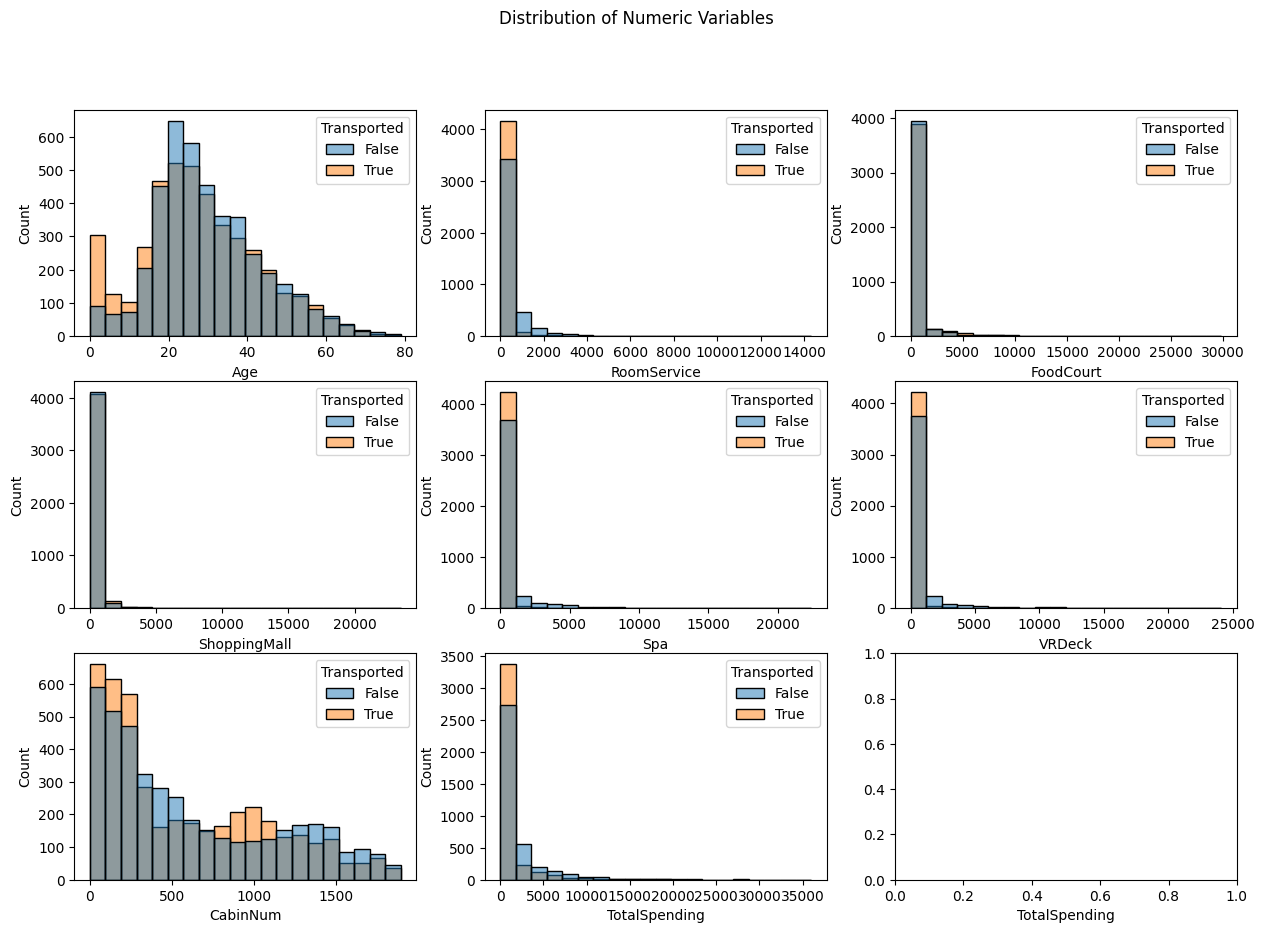

In [152]:
# Get numeric colummn names
numeric_vars = train_df.select_dtypes(include="number").columns.tolist()

# Establish subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))


# Loop through numeric columns and plot histograms on subplots
for i in range(len(numeric_vars)):
    if i < 3:
        sns.histplot(
            data=train_df,
            x=numeric_vars[i],
            hue="Transported",
            bins=20,
            ax=axes[0, i],
        )
    elif i > 5:
        sns.histplot(
            data=train_df,
            x=numeric_vars[i],
            hue="Transported",
            bins=20,
            ax=axes[2, (i - 6)],
        )
    else:
        sns.histplot(
            data=train_df,
            x=numeric_vars[i],
            hue="Transported",
            bins=20,
            ax=axes[1, (i - 3)],
        )
    plt.xlabel(f"{numeric_vars[i]}")
plt.suptitle(f"Distribution of Numeric Variables")
plt.show()

### Categorical Graphs

In [153]:
cat_vars = train_df.select_dtypes(include="object").columns.tolist()
cat_vars

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Name',
 'Deck',
 'Side']

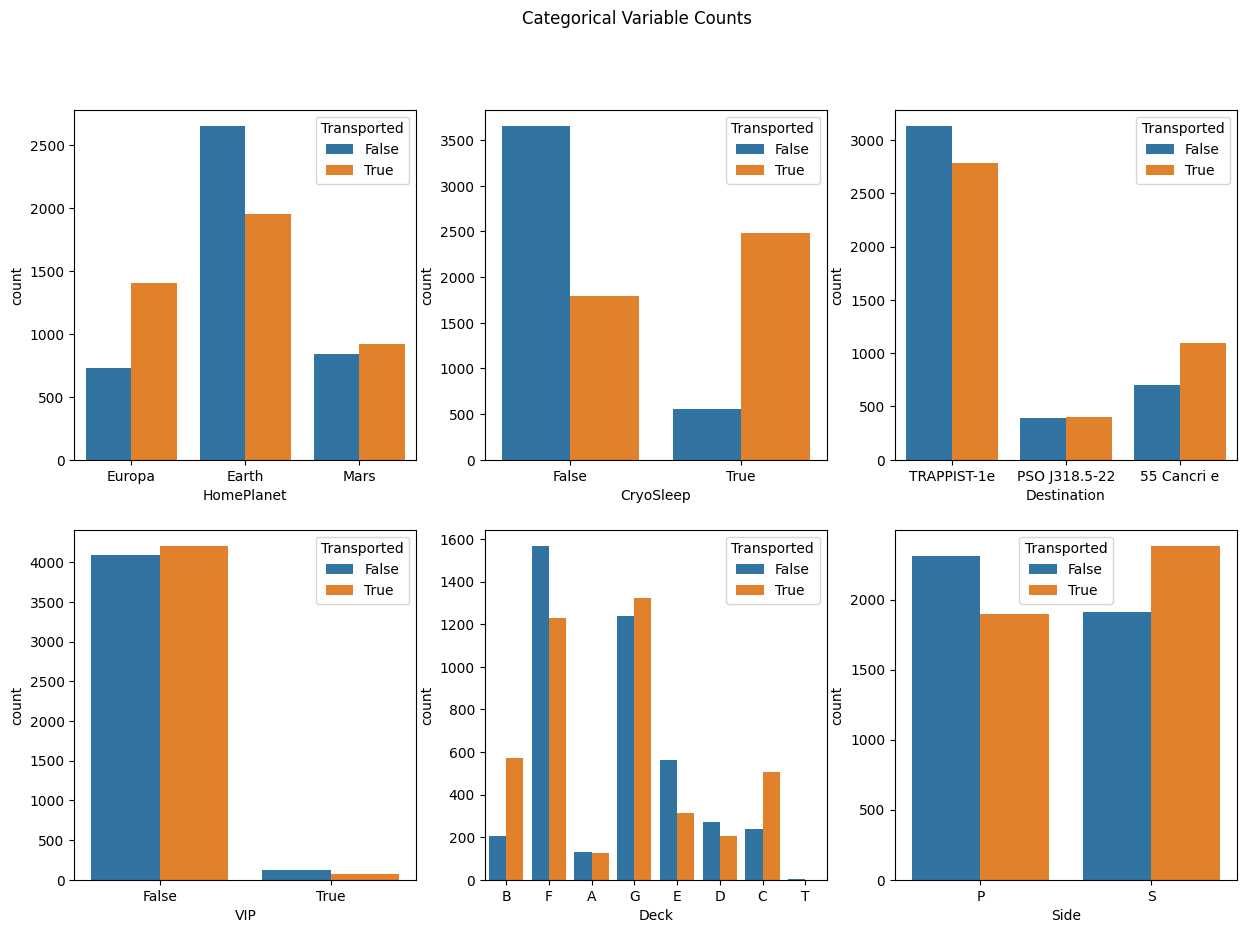

In [154]:
# Get categorical colummn names
cat_vars = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side"]

# setup subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

#
for i in range(len(cat_vars)):
    if i < 3:
        sns.countplot(
            x=cat_vars[i], hue="Transported", data=train_df, ax=axes[0, i]
        )
    else:
        sns.countplot(
            x=cat_vars[i], hue="Transported", data=train_df, ax=axes[1, i - 3]
        )
plt.suptitle(f"Categorical Variable Counts")
plt.show()

## VIP
The VIP variable shows the majority of the passengers not having VIP, and no signifigant difference in survival rate between VIP and non-VIP passengers.

Because of this we will drop this row from our dataset as it will not be useful in our model.

# Null Value Imputation

we will create clusters with our data, then impute null values with the median from the cluster they are in

In [155]:
numeric_vars

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'CabinNum',
 'TotalSpending']

In [156]:
cat_vars

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

In [157]:
nan_cols = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "Age",
    "VIP",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Name",
    "Deck",
    "CabinNum",
    "Side",
    "TotalSpending",
]

train_df.isna().any()

PassengerId      False
HomePlanet        True
CryoSleep         True
Destination       True
Age               True
VIP               True
RoomService       True
FoodCourt         True
ShoppingMall      True
Spa               True
VRDeck            True
Name              True
Transported      False
Deck              True
CabinNum          True
Side              True
TotalSpending     True
dtype: bool

In [158]:
# Impute missing values with mean for numerical and mode for categorical
for col in nan_cols:
    if col in numeric_vars:
        train_df[col].fillna(train_df[col].mean(), inplace=True)
    elif col in cat_vars:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

train_df.isna().any()

PassengerId      False
HomePlanet       False
CryoSleep        False
Destination      False
Age              False
VIP              False
RoomService      False
FoodCourt        False
ShoppingMall     False
Spa              False
VRDeck           False
Name              True
Transported      False
Deck             False
CabinNum         False
Side             False
TotalSpending    False
dtype: bool

In [161]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,CabinNum,Side,TotalSpending
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P,0.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S,736.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S,1091.0


In [159]:
unique_cols = ["Name", "PassengerId"]
labels = ["Transported"]

X = train_df.copy().drop(unique_cols + labels, axis=1)
y = train_df[labels]

In [160]:
pipe0 = ColumnTransformer(
    [
        ("OneHot", OneHotEncoder(), cat_vars),
        ("scale", StandardScaler(), numeric_vars),
    ]
)

pipe1 = Pipeline([("preprocess", pipe0), ("pca", PCA(n_components=2))])

pca_data = pipe1.fit_transform(X)